# Object detection on MRI brain images

* Downloading dataset of three modalities (axial sagittal coronal)
* Copying all to folder `data`
* Split `data` set into `train` and `validation` set

In [1]:
import kagglehub
import random, os
data_set_path = kagglehub.dataset_download("davidbroberts/brain-tumor-object-detection-datasets")

root='datasets'
!rm -rf {root}
!mkdir -p {root}/train/images
!mkdir -p {root}/train/labels
!mkdir -p {root}/validation/images
!mkdir -p {root}/validation/labels
!cp -n {data_set_path}/**/images/train/* {root}/train/images
!cp -n {data_set_path}/**/labels/train/* {root}/train/labels

traning_validation_split = .8
data_size = int(len(os.listdir(f'{root}/train/images')))
training_data_size = int(data_size * traning_validation_split)
validation_data_size = data_size - training_data_size

print(f'Training data size: {training_data_size}')
print(f'Validation data size: {validation_data_size}')

def move_data(source_dir, target_dir, n_files):
  all_images = os.listdir(f'{root}/train/images')
  random.shuffle(all_images)
  images_to_move = all_images[:validation_data_size]

  for image_name in images_to_move:
      label_name = image_name.replace('.jpg', '.txt')
      label_path = f'{source_dir}/labels/{label_name}'
      if os.path.exists(label_path):
          os.rename(f'{source_dir}/images/{image_name}', f'{target_dir}/images/{image_name}')
          os.rename(label_path, f'{target_dir}/labels/{label_name}')
      else:
          print(image_name + ' is missing label ' + label_path + ', ignoring.')

move_data(f'{root}/train', f'{root}/validation', validation_data_size)

Training data size: 714
Validation data size: 179
00406_98.jpg is missing label datasets/train/labels/00406_98.txt, ignoring.
00364_120.jpg is missing label datasets/train/labels/00364_120.txt, ignoring.


Define dataset class to init and load data

In [2]:
!pip install pyyaml > /dev/null

import os
import yaml
import torch
from torch.utils.data import Dataset
from PIL import Image
from pathlib import Path

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.transform = transform

        image_paths = []
        label_paths = []

        self.populate(image_paths, images_dir)
        self.populate(label_paths, labels_dir)

        def basename(path):
            return os.path.splitext(os.path.basename(path))[0]

        image_basenames = {basename(path) for path in image_paths}
        label_basenames = {basename(path) for path in label_paths}
        matching_basenames = image_basenames & label_basenames

        self.image_paths = [path for path in image_paths if basename(path) in matching_basenames]
        self.label_paths = [path for path in label_paths if basename(path) in matching_basenames]

    def populate(self, file_paths, dir):
      for dir_path, dir_names, file_names in os.walk(dir):
          for file_name in file_names:
              file_path = os.path.join(dir_path, file_name)
              file_paths.append(file_path)
      file_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def extract_label(self, label_path, image_width, image_height):
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                def scale(center, size, factor):
                    scaled_center = center * factor
                    scaled_size = size * factor
                    half_size = scaled_size / 2
                    return scaled_center - half_size, scaled_center + half_size

                columns = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, columns[:5])
                class_id = int(class_id)

                x_min, x_max = scale(x_center, width, image_width)
                y_min, y_max = scale(y_center, height, image_height)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return boxes, labels

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        image_width, image_height = image.size

        label_path = self.label_paths[idx]
        boxes, labels = self.extract_label(label_path, image_width, image_height)

        if self.transform:
           image = self.transform(image)
           resize_scale = torch.tensor([image.shape[2] / image_height, image.shape[1] / image_width] * 2)
           boxes = boxes * resize_scale

        return {'image': image, 'boxes': boxes, 'labels': labels}

def collate_fn(batch):
    images = [item['image'] for item in batch]
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]

    return {
        'images': torch.stack(images, dim=0),
        'boxes': boxes,
        'labels': labels
    }

Instantiate batch data loaders

In [3]:
from torch.utils.data import DataLoader
from torchvision import transforms

target_image_size = 256
transform = transforms.Compose([
    transforms.Resize((target_image_size, target_image_size)),
    transforms.ToTensor(),
])

train_dataset = BrainTumorDataset(
    images_dir=root+'/train/images',
    labels_dir=root+'/train/labels',
    transform=transform
)

validation_dataset = BrainTumorDataset(
  images_dir=root+'/validation/images',
    labels_dir=root+'/validation/labels',
    transform=transform
)

torch.manual_seed(0)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

Visualize sample data from training and validation set

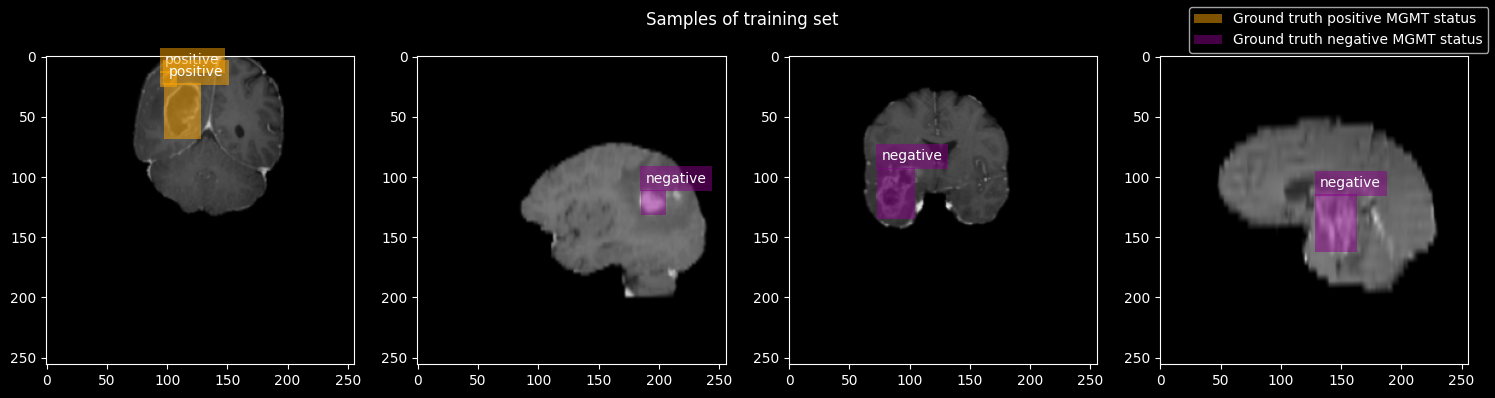

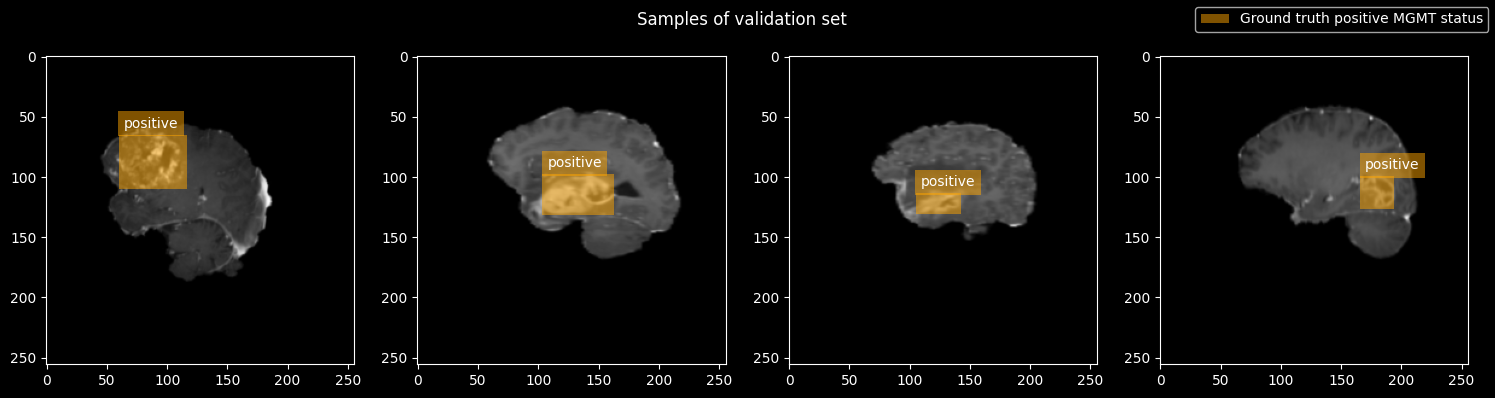

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import numpy as np
from collections import OrderedDict

plt.style.use('dark_background')

class_labels = {
    0: 'negative',
    1: 'positive',
    2: 'background'
}
class_colors = {
    'negative': 'darkmagenta',
    'positive': 'orange',
    'background': 'black'
}
        
def plot_boxes(ax, image, boxes, labels, prediction_confidences=None):
    ax.imshow(image)
    for i, label in enumerate(labels):
        x_min, y_min, x_max, y_max = boxes[i]
        width, height = x_max - x_min,  y_max - y_min

        legend = ('positive' if label.item() == 1 else 'negative') + ' MGMT status'
        class_label = class_labels[label.item()]
        class_color = class_colors[class_label]
        bounding_box = plt.Rectangle((x_min, y_min),
                                     width, height,
                                     linewidth=3.5,
                                     label=legend)
        label_text = ax.text(x_min+4, y_min-6, class_label)
        label_text.set_bbox(dict(facecolor=to_rgba(class_color, alpha=.5)))
        if prediction_confidences is not None:
            label_text.set_position((x_min+4, y_max+14))
            confidence_label = f' conf: {prediction_confidences[i]:.2f}'
            bounding_box.set_edgecolor(class_color)
            bounding_box.set_facecolor('none')
            bounding_box.set_label('Predicted ' + legend)
            label_text.set_text(class_label + confidence_label)
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor(class_color)
            label_box.set_facecolor('none')
            label_box.set_linewidth(3)  
        else:
            bounding_box.set_label('Ground truth ' + legend)
            bounding_box.set_edgecolor('none')
            bounding_box.set_facecolor(to_rgba(class_color, alpha=.5))
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor('none')
        ax.add_patch(bounding_box)

def add_legends(fig):
    box_legends = [ax.get_legend_handles_labels() for ax in fig.axes]
    box_legends, labels = [sum(lol, []) for lol in zip(*box_legends)]
    box_labeled_legends = OrderedDict(zip(labels, box_legends))
    fig.legend(box_labeled_legends.values(), box_labeled_legends.keys())

def visualize_data(data_loader, title):
    cols = 4
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(15 * rows, cols))
    axes = axes.flatten()
    batch = next(iter(data_loader))
    fig.suptitle(title)

    for i in range(cols * rows):
        image = batch['images'][i].permute(1, 2, 0).numpy()
        boxes = batch['boxes'][i]
        labels = batch['labels'][i]
        plot_boxes(axes[i], image, boxes, labels)
        plt.tight_layout()
    add_legends(fig)
    plt.show()

visualize_data(train_loader, 'Samples of training set')
visualize_data(validation_loader, 'Samples of validation set')

Download pretrained model

In [5]:
# Using Ultralytics pretrained model
# Jocher, G., Qiu, J., & Chaurasia, A. (2023). Ultralytics YOLO (Version 8.0.0) [Computer software]. https://github.com/ultralytics/ultralytics

!pip install ultralytics > /dev/null
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 > /dev/null
from ultralytics import YOLO

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
print('Using device:', device)

!rm runs -rf
model = YOLO('yolo11n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


100%|██████████| 5.35M/5.35M [00:00<00:00, 75.8MB/s]


Configure data paths and train model on MRI data

In [6]:
import yaml

data = {
    'path': './',
    'train': 'train',
    'val': 'validation',
    'nc': 2,
    'names': ['negative', 'positive']
}

with open(f'{root}/data.yaml', 'w') as f:
    yaml.dump(data, f)

model.train(data=root+'/data.yaml', 
            epochs=100, 
            imgsz=target_image_size, 
            batch=32,
            device=device, 
            patience=5,
            dropout=1e-2,
            lr0=5e-2,
            verbose=False,
           )

engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=datasets/data.yaml, epochs=100, time=None, patience=5, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.01, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dyna

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]
2024-12-26 14:30:00,268	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-26 14:30:01,575	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/datasets/train/labels... 701 images, 15 backgrounds, 0 corrupt: 100%|██████████| 716/716 [00:00<00:00, 1078.81it/s]

train: New cache created: /kaggle/working/datasets/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/validation/labels... 177 images, 0 backgrounds, 0 corrupt: 100%|██████████| 177/177 [00:00<00:00, 1081.19it/s]

val: New cache created: /kaggle/working/datasets/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       0.9G       1.74      3.673      1.209         25        256: 100%|██████████| 23/23 [00:04<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

                   all        177        183    0.00314      0.866     0.0133    0.00789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.818G       1.48      1.933      1.028         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        183    0.00311      0.899      0.295      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.826G       1.32      1.628      1.007         17        256: 100%|██████████| 23/23 [00:02<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.89it/s]

                   all        177        183      0.831     0.0361      0.425      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.826G       1.34      1.562     0.9938         21        256: 100%|██████████| 23/23 [00:02<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all        177        183      0.468      0.331      0.453      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.826G      1.331      1.516      1.003         17        256: 100%|██████████| 23/23 [00:02<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.75it/s]


                   all        177        183      0.465      0.651      0.448      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.826G      1.333      1.486      1.017         15        256: 100%|██████████| 23/23 [00:02<00:00,  8.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.76it/s]


                   all        177        183      0.452      0.693      0.485      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.826G      1.302      1.378     0.9946         17        256: 100%|██████████| 23/23 [00:02<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        183       0.44      0.686      0.488      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.826G      1.246      1.351     0.9983         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.18it/s]

                   all        177        183      0.457      0.752      0.509      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.826G      1.206      1.301     0.9881         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all        177        183       0.49      0.706      0.531       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.824G       1.25      1.289      1.004         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]

                   all        177        183      0.498      0.789      0.548      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.824G      1.202      1.252     0.9876         13        256: 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.86it/s]

                   all        177        183      0.538      0.784      0.594      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.826G      1.257      1.265     0.9986         21        256: 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all        177        183      0.462      0.822      0.541      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.824G      1.194      1.209     0.9815         15        256: 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all        177        183      0.524      0.677      0.555      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.826G      1.185      1.191     0.9923         21        256: 100%|██████████| 23/23 [00:02<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.46it/s]

                   all        177        183      0.529       0.74       0.65      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.824G      1.153      1.157     0.9793         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.28it/s]

                   all        177        183      0.479      0.611      0.482      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.826G      1.161      1.184      0.971         18        256: 100%|██████████| 23/23 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]

                   all        177        183      0.484      0.767      0.583      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.824G       1.14      1.123     0.9663         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all        177        183      0.497      0.814      0.639       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.826G      1.143      1.136     0.9689         23        256: 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all        177        183      0.518      0.752      0.659       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.824G      1.147      1.141     0.9671         17        256: 100%|██████████| 23/23 [00:02<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.41it/s]

                   all        177        183      0.529      0.836      0.673      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.824G      1.162      1.133     0.9888         15        256: 100%|██████████| 23/23 [00:02<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all        177        183      0.541       0.73      0.648      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.824G      1.124      1.062     0.9521         22        256: 100%|██████████| 23/23 [00:02<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all        177        183      0.542      0.777      0.661      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.826G      1.116      1.122      0.956         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.73it/s]

                   all        177        183      0.448      0.838      0.668      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.824G      1.153      1.136     0.9664         14        256: 100%|██████████| 23/23 [00:02<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all        177        183      0.564      0.752      0.674       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.824G      1.102      1.052     0.9624         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.29it/s]

                   all        177        183      0.552      0.811      0.667      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.824G       1.09      1.074     0.9475         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]

                   all        177        183      0.656      0.778      0.705      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.824G      1.113      1.055     0.9612         14        256: 100%|██████████| 23/23 [00:02<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.38it/s]

                   all        177        183      0.576      0.816      0.749      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.824G      1.126      1.065     0.9742         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]

                   all        177        183      0.565      0.788      0.673      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.826G      1.103      1.088     0.9597         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.23it/s]

                   all        177        183      0.578      0.794       0.72      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.824G       1.08      1.011     0.9501         21        256: 100%|██████████| 23/23 [00:02<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.33it/s]

                   all        177        183      0.664      0.726      0.746      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.824G      1.109       1.05     0.9502         21        256: 100%|██████████| 23/23 [00:02<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.39it/s]

                   all        177        183      0.642      0.728       0.73      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.824G      1.073      1.013     0.9477         26        256: 100%|██████████| 23/23 [00:02<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.56it/s]

                   all        177        183      0.645      0.829       0.76      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.826G      1.096      1.032     0.9433         24        256: 100%|██████████| 23/23 [00:02<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]

                   all        177        183      0.624      0.719      0.721      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.824G       1.06      1.018     0.9396         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all        177        183      0.636      0.769      0.746      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.824G      1.081      1.028     0.9609         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]

                   all        177        183      0.507      0.735      0.608      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.824G      1.069     0.9816     0.9426         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.24it/s]

                   all        177        183      0.753      0.766      0.797      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.826G      1.033     0.9252     0.9331         22        256: 100%|██████████| 23/23 [00:02<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.05it/s]

                   all        177        183      0.684      0.685      0.753      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.824G      1.034     0.9502      0.936         20        256: 100%|██████████| 23/23 [00:02<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.32it/s]

                   all        177        183      0.612      0.799      0.749       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.824G      1.016     0.9693     0.9335         12        256: 100%|██████████| 23/23 [00:02<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.65it/s]

                   all        177        183      0.604      0.806      0.713      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.824G      1.029     0.9542     0.9261         25        256: 100%|██████████| 23/23 [00:02<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all        177        183      0.716      0.791       0.81       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.824G      1.023     0.9124     0.9252         17        256: 100%|██████████| 23/23 [00:02<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.00it/s]

                   all        177        183      0.642      0.731      0.761      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.824G      1.041      0.922     0.9228         19        256: 100%|██████████| 23/23 [00:02<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.21it/s]

                   all        177        183       0.54      0.794      0.686        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.824G      1.073     0.9278     0.9406         21        256: 100%|██████████| 23/23 [00:02<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.50it/s]

                   all        177        183      0.752      0.741      0.788       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.824G      1.015     0.9006     0.9217         16        256: 100%|██████████| 23/23 [00:02<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.58it/s]

                   all        177        183      0.687      0.753      0.764      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.824G      1.019     0.9055     0.9198         14        256: 100%|██████████| 23/23 [00:02<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all        177        183      0.624      0.789      0.749      0.553
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



44 epochs completed in 0.048 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.55 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


                   all        177        183      0.712      0.788       0.81      0.592
Speed: 0.0ms preprocess, 0.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d7aa4d3bee0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

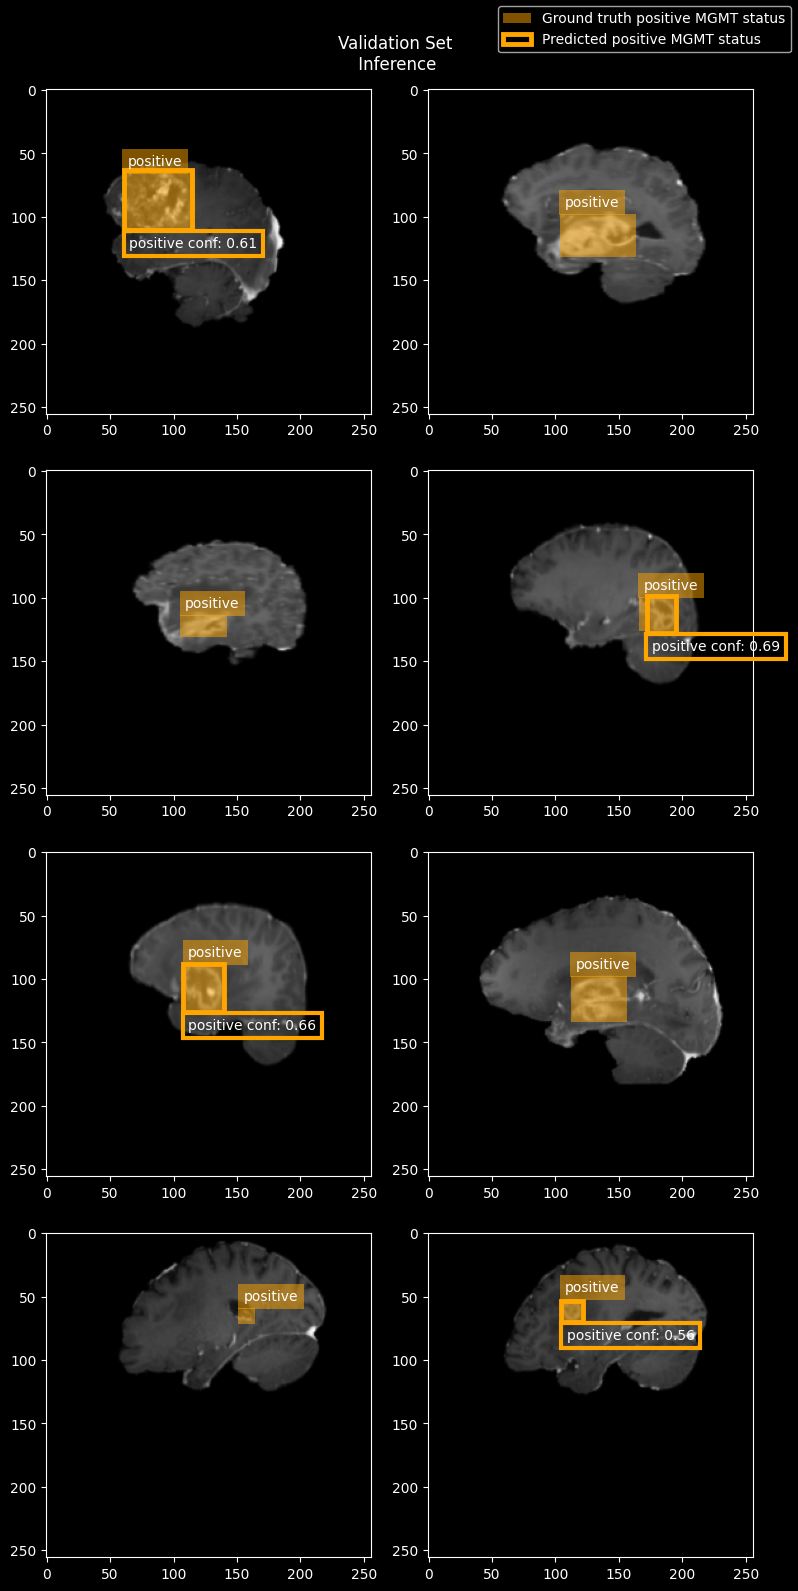

In [7]:
confidence_threshold = .5

def visualize_inference(model, data_loader, title):
      rows = 4
      cols = 2
      fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows * 4))
      axes = axes.flatten()
      plt.suptitle(title)
      batch = next(iter(data_loader))
      predictions = model.predict(batch['images'].half().to(device), verbose=False)
      for i, prediction in enumerate(predictions):
          if i > rows * cols - 1:
              break
          image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
          boxes = batch['boxes'][i]
          labels = batch['labels'][i]
          plot_boxes(axes[i], image, boxes, labels)

          boxes = prediction.boxes.xyxy
          scores = prediction.boxes.conf
          classes = prediction.boxes.cls
          confident_prediction_indices = scores > confidence_threshold
          boxes = boxes[confident_prediction_indices].cpu()
          scores = scores[confident_prediction_indices].cpu()
          classes = classes[confident_prediction_indices].cpu()
          plot_boxes(axes[i], image, boxes, classes, scores)

          plt.tight_layout()
      add_legends(fig)
      plt.show()

best_models = !find runs -name best.pt | sort
model = YOLO(best_models[-1])
model.eval()
visualize_inference(model, validation_loader, 'Validation Set\n Inference')

In [8]:
import torch
import numpy as np
from torchvision.ops import box_iou

num_classes = len(class_labels)
def calculate_precision_recall(pred_boxes, pred_labels, true_boxes, true_labels, iou_threshold, device='cpu'):
    pred_boxes = pred_boxes.clone().detach().to(device)
    pred_labels = pred_labels.clone().detach().to(device)
    true_boxes = true_boxes.clone().detach().to(device)
    true_labels = true_labels.clone().detach().to(device)
    
    iou_matrix = box_iou(true_boxes, pred_boxes)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    matched_true_boxes = set()
    for prediction_idx, (pred_box, pred_label) in enumerate(zip(pred_boxes, pred_labels)):
        best_iou = 0
        best_ground_truth_idx = -1
        pred_label = int(pred_label.item())

        for ground_truth_idx, (true_box, true_label) in enumerate(zip(true_boxes, true_labels)):
            if ground_truth_idx in matched_true_boxes:
                continue  # Skip already matched ground truth boxes

            current_iou = iou_matrix[ground_truth_idx, prediction_idx].item()
            if current_iou > best_iou:
                best_iou = current_iou
                best_ground_truth_idx = ground_truth_idx

        if best_iou >= iou_threshold and best_ground_truth_idx != -1:
            matched_true_boxes.add(best_ground_truth_idx)
            true_label = true_labels[best_ground_truth_idx].item()
            confusion_matrix[true_label, pred_label] += 1
        else:
            confusion_matrix[2, pred_label] += 1

    for ground_truth_idx, true_label in enumerate(true_labels):
        if ground_truth_idx not in matched_true_boxes:
            true_label = true_labels[ground_truth_idx].item()
            confusion_matrix[true_label, 2] += 1
            
    tp = confusion_matrix[0, 0] + confusion_matrix[1, 1] 
    fp = confusion_matrix[0, 1] + confusion_matrix[2, 1]
    fn = confusion_matrix[1, 0] + confusion_matrix[2, 0]

    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0

    return precision, recall, confusion_matrix


def evaluate(iou_threshold):
    with torch.no_grad():
        total_precision = 0.
        total_recall = 0.
        num_samples = 0
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for batch in validation_loader:
            predictions = model.predict(batch['images'].half().to(device), verbose=False);
            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction.boxes.xyxy
                predicted_scores = prediction.boxes.conf
                predicted_classes = prediction.boxes.cls
                confident_prediction_indices = predicted_scores > confidence_threshold
                predicted_boxes = predicted_boxes[confident_prediction_indices]
                predicted_scores = predicted_scores[confident_prediction_indices]
                predicted_classes = predicted_classes[confident_prediction_indices]
                ground_truth_boxes = batch['boxes'][i]
                ground_truth_labeles = batch['labels'][i]
                
                precision, recall, batch_confusion_matrix = calculate_precision_recall(predicted_boxes,
                                                                                       predicted_classes,
                                                                                       ground_truth_boxes,
                                                                                       ground_truth_labeles,
                                                                                       iou_threshold)
                confusion_matrix += batch_confusion_matrix
                total_precision += precision
                total_recall += recall
                num_samples += 1
        mean_precision = total_precision / num_samples if num_samples > 0 else 0
        mean_recall = total_recall / num_samples if num_samples > 0 else 0

        return mean_precision, mean_recall, confusion_matrix

mean_precision, mean_recall, confusion_matrix = evaluate(iou_threshold=.5);

Mean Precision: 0.4350, Mean Recall: 0.4350


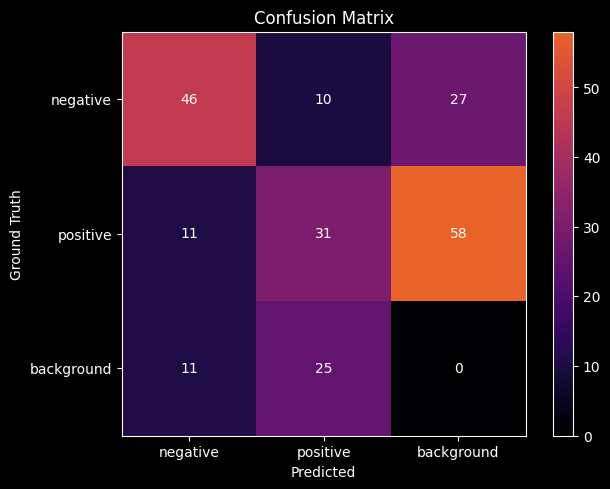

In [9]:
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(confusion_matrix):
    cmap = plt.get_cmap('inferno')
    colors = cmap(np.linspace(0., .65, cmap.N // 2))
    heatmap = LinearSegmentedColormap.from_list('Upper Half', colors)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=heatmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, list(class_labels.values()))
    plt.yticks(tick_marks, list(class_labels.values()))

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, confusion_matrix[i, j], color='white',
                     ha='center', va='center')

    plt.tight_layout()
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted')
    plt.show()

print(f"Mean Precision: {mean_precision:.4f}, Mean Recall: {mean_recall:.4f}")
plot_confusion_matrix(confusion_matrix)

Many false predictions appear, one explanation is that the training data set is small, and has many wrong labels.